In [31]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

In [32]:
print(tf.__version__)

2.12.0


In [33]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics
        print(self.print_metrics)

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x and x in self.print_metrics]

        f, axs = plt.subplots(len(metrics)//2 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['loss']))*0.8, max(max(history.history['loss']), max(history.history['loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [35]:
dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['time_as_client', 'profit', 'compliant'])

target = 'monthly_spend'
dataset['cheat'] = dataset[target]

In [36]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [37]:
train_features = train_dataset.copy()


In [38]:
test_features = test_dataset.copy()

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

In [39]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


[[1.84504643e-01 5.91180742e-01 1.08865447e-01 1.15449406e-01
  1.95682094e-01 5.22278368e-01 1.97519511e-01 8.31419453e-02
  4.28165723e+03 1.23719934e+03 6.41249418e-01 3.04445752e+03
  4.35261106e+00 5.13817078e+02 5.17495544e+02 4.67582275e+02
  2.49653198e+02 3.94049133e+02 8.71046094e+03 7.87867334e+03
  7.85896540e-01 1.03611108e+03]]


In [40]:
first = np.array(train_features[:1])

with np.printoptions(precision=4, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   1.        0.        0.        0.        0.        0.        1.
     0.     4000.     1450.        0.     2550.        1.35    586.
   359.      595.      319.      617.     5500.     5400.        0.9818
   765.    ]]

Normalized: [[ 2.1024 -1.2025 -0.3495 -0.3613 -0.4932 -1.0456  2.0156 -0.3011 -0.0805
   0.1989 -1.337  -0.1558 -0.2526  0.3291 -0.6453  0.8032  0.2829  1.432
  -0.4061 -0.3137  1.0641 -0.2255]]


In [41]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='relu'),
        # layers.Dense(8, activation='relu'),
        # layers.Dense(8, activation='sigmoid'),
        layers.Dense(1)
    ])


    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.5,
                    decay_steps = 1000,
                    decay_rate=10,
                    staircase=False)
    
    model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))

    model.save_weights('initial_mspend_model.h5')
    
    return model



In [42]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 22)               45        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 32)                736       
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 814
Trainable params: 769
Non-trainable params: 45
_________________________________________________________________


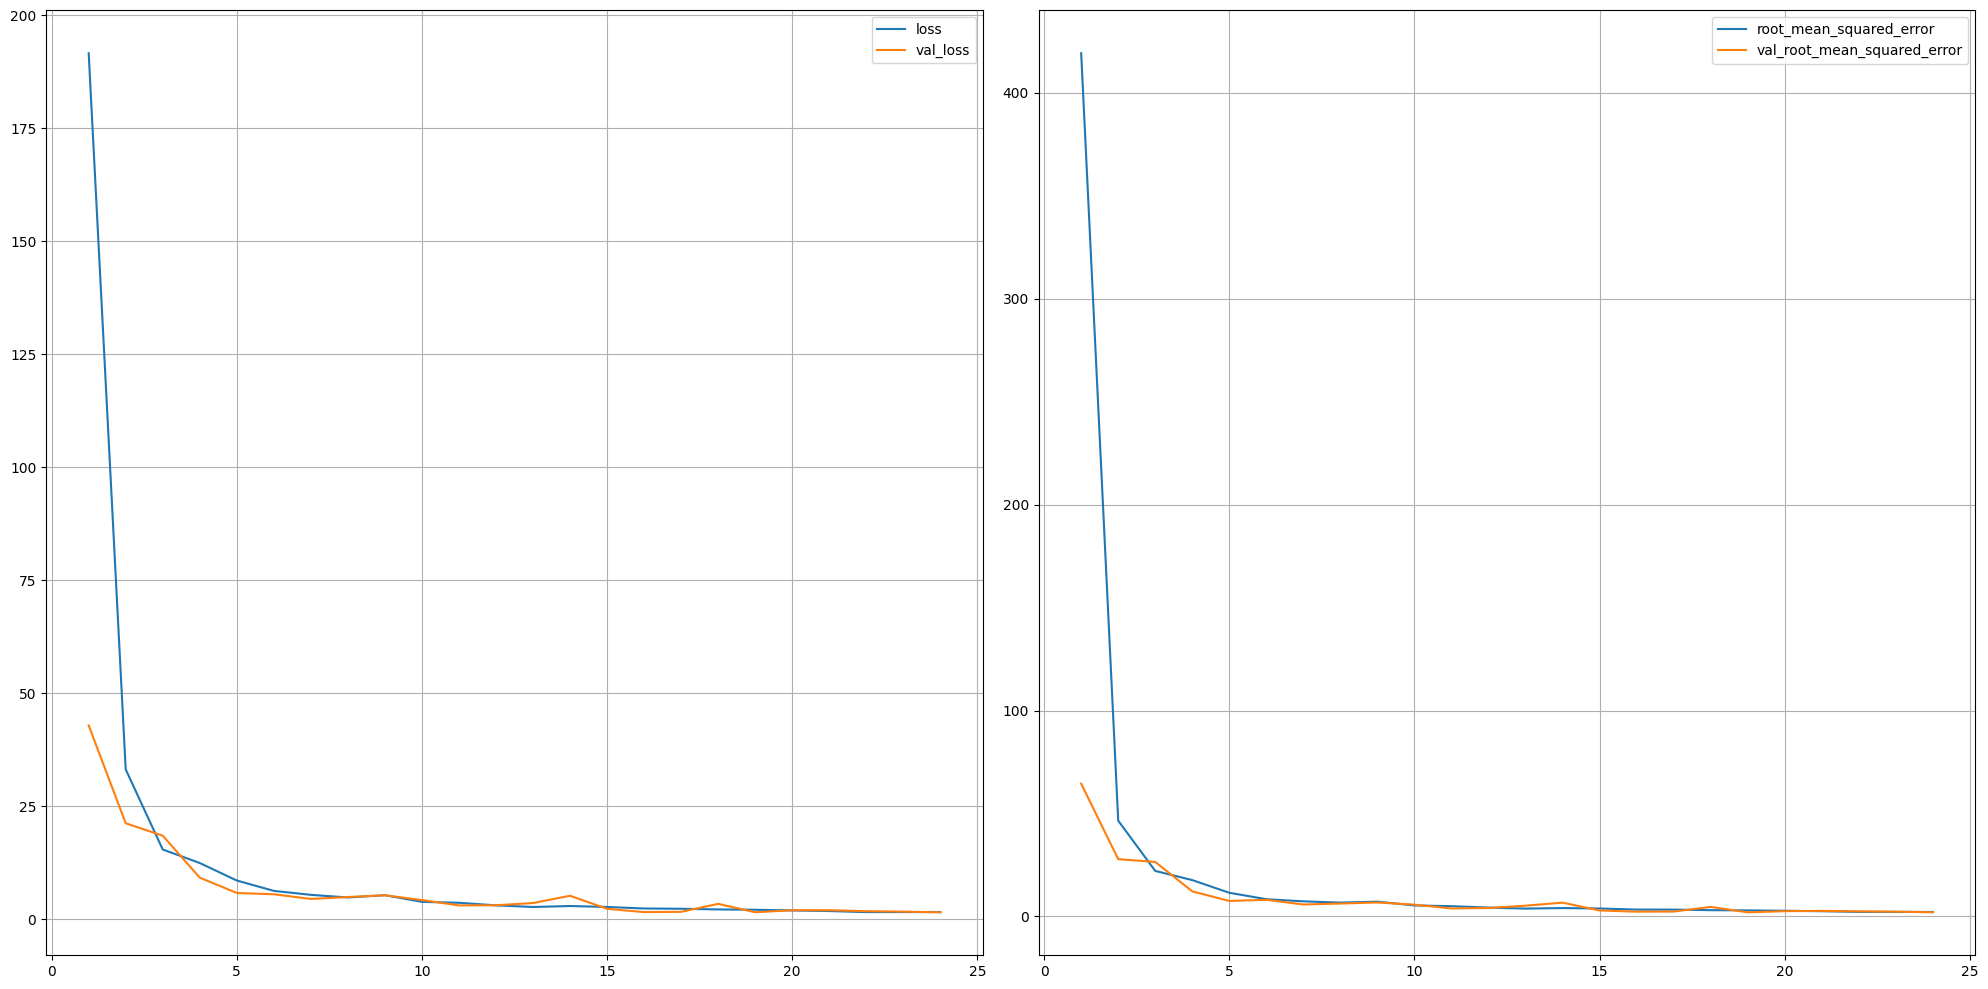

164/164 [==============================] - 1s 3ms/step - loss: 1.6416 - root_mean_squared_error: 2.1875 - val_loss: 1.5845 - val_root_mean_squared_error: 2.0303


In [43]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  # tfdocs.modeling.EpochDots(),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=200,
    callbacks=callbacks_list)

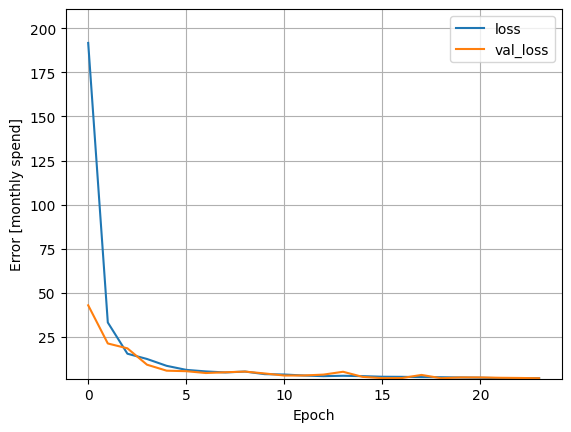

In [44]:
plot_loss(history)

52/52 [==============================] - 0s 780us/step


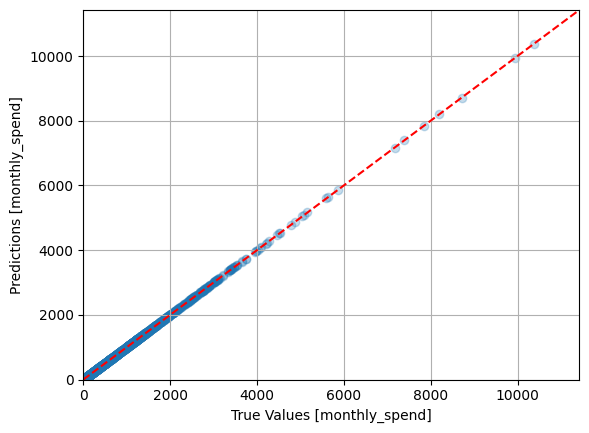

In [45]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [0, max(test_predictions)*1.1]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

In [ ]:
error = test_predictions - test_labels
sns.displot(error, bins=100, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
plt.ylabel('Count')